<a href="https://colab.research.google.com/github/Shayshoon/ML_2/blob/main/HW2_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HW1 - Data Exploration and Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the dataset

In [2]:
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

rm: cannot remove '*.csv': No such file or directory
Please load the raw csv data


Saving virus_data.csv to virus_data.csv


In [3]:
dataset = pd.read_csv(filename)

In [4]:
dataset.shape

(1250, 25)

# How to download from Colab?

In [5]:
# from google.colab import files
# outputPath = "saved_file.csv"
# dataset.to_csv(outputPath)
# files.download(outputPath)

In [6]:
from sklearn.model_selection import train_test_split

# partition data like in hw1
raw_train_df, raw_test_df = train_test_split(dataset, test_size=0.2, random_state=15)

In [7]:
# @title Default title text
def prepare_data(training_data, new_data):
	import numpy as np
	import pandas as pd
	from sklearn.preprocessing import MinMaxScaler, StandardScaler

	# fill null values
	fillna_values = {"household_income": training_data.household_income.median(),
	 				 "PCR_02": training_data.PCR_02.median()}
	prepared_data = new_data.fillna(value=fillna_values)

	# scale using minmax

	minmax_scaler = MinMaxScaler(feature_range=(-1,1))
	minmax_features = ['PCR_01','PCR_03','PCR_04','PCR_06','PCR_07','PCR_08', 'PCR_09']

	minmax_scaler.fit(training_data[minmax_features])
	prepared_data[minmax_features] = minmax_scaler.transform(prepared_data[minmax_features])

	# scale using standard

	standard_scaler = StandardScaler()
	standard_features = ['PCR_02','PCR_05','PCR_10']

	standard_scaler.fit(training_data[standard_features])
	prepared_data[standard_features] = standard_scaler.transform(prepared_data[standard_features])

	# generate new feature `blood_type_group`

	prepared_data['blood_type_group'] = prepared_data['blood_type'].isin(["O+", "B+"])
# drop useless features (this step was changed from hw1, because we dropped the `blood_type` feature too.)
	prepared_data = prepared_data.drop(columns=['pcr_date', 'current_location'])

	return prepared_data


In [8]:
# Make sure target variables follow {1,-1} convention
dataset[['spread', 'risk']].value_counts()

spread  risk
 1      -1      340
         1      316
-1       1      311
        -1      283
Name: count, dtype: int64

In [9]:
# preprocess data

test_df = prepare_data(raw_train_df, raw_test_df)
train_df = prepare_data(raw_train_df, raw_train_df)
train_df.head()

,patient_id,age,sex,weight,blood_type,num_of_siblings,happiness_score,household_income,PCR_02,conversations_per_day,...,PCR_04,PCR_05,PCR_06,PCR_07,PCR_08,PCR_09,PCR_10,spread,risk,blood_type_group
310,437,14,M,52.8,O+,1,11,1.1,-0.083981,3,...,-0.039442,-0.004755,0.402184,0.178861,0.688339,0.026753,0.567053,-1,-1,True
136,1154,14,M,31.0,A+,1,6,1.5,-0.066199,2,...,0.412701,-1.076106,-0.600375,-0.106911,-0.407475,-0.273356,-0.473228,-1,1,False
566,64,44,M,86.1,A+,4,10,0.7,0.177198,3,...,0.516575,0.667674,0.726105,-0.097657,0.268758,-0.391250,-0.934783,-1,1,False
556,59,28,F,63.4,O+,2,8,0.3,-0.337062,3,...,0.186993,-0.194558,-0.099422,-0.210236,0.073719,-0.683579,-0.598048,1,1,True
813,1185,47,M,82.0,O+,0,9,1.0,-0.296556,3,...,-0.474648,0.280618,-0.487620,0.299462,-0.472796,0.203909,2.119547,-1,1,True


# Part 1

In [10]:
# @title Default title text
def visualize_clf(clf, X, Y, title,
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)

    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()


In [11]:
temp_train_df = train_df[['PCR_08','PCR_01','spread']]
temp_test_df = test_df[['PCR_08','PCR_01','spread']]

In [12]:
from sklearn.neighbors import KNeighborsClassifier

q1_classifier = KNeighborsClassifier(n_neighbors=1)

q1_classifier.fit(X=temp_train_df[['PCR_01','PCR_08']], y=temp_train_df['spread'])
q1_train_accuracy = q1_classifier.score(temp_train_df[['PCR_01', 'PCR_08']], temp_train_df['spread'])
q1_test_accuracy = q1_classifier.score(temp_test_df[['PCR_01', 'PCR_08']], temp_test_df['spread'])


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


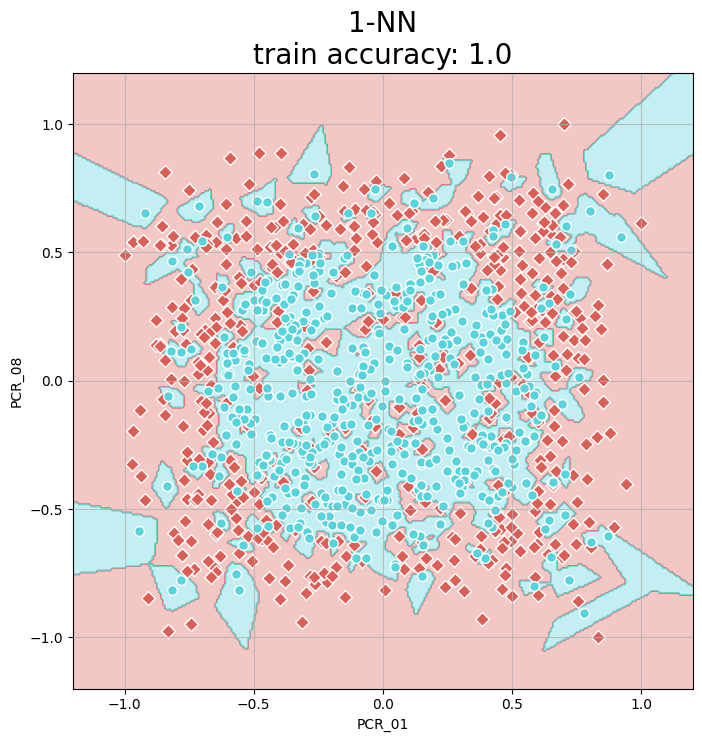

In [13]:
visualize_clf(q1_classifier, temp_train_df[['PCR_01', 'PCR_08']], temp_train_df['spread'],
              f'1-NN\ntrain accuracy: {q1_train_accuracy}', 'PCR_01', 'PCR_08')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


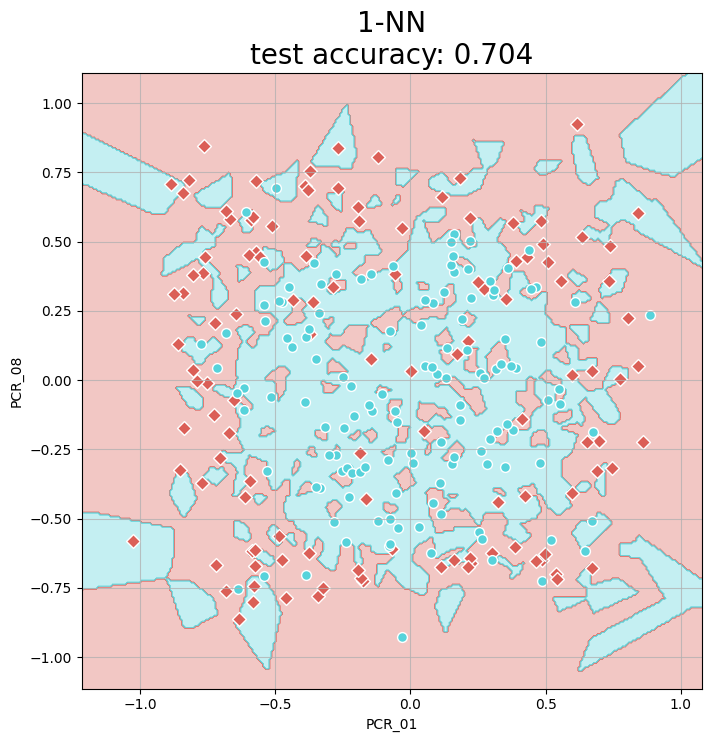

In [14]:
visualize_clf(q1_classifier, temp_test_df[['PCR_01', 'PCR_08']], temp_test_df['spread'],
              f'1-NN\ntest accuracy: {q1_test_accuracy}', 'PCR_01', 'PCR_08')

In [15]:
def q2_range():
  for i in range(1, 20, 2):
    yield i
  for i in range(20, 695, 65):
    yield i

In [16]:
from sklearn.model_selection import cross_validate

h_parameters = pd.DataFrame({"k": [], "test_score": [], "train_score": []})
folds = 8
for k in q2_range():
  res = cross_validate(KNeighborsClassifier(n_neighbors=k), temp_train_df[['PCR_01', 'PCR_08']], y=temp_train_df['spread'], cv=folds, return_train_score=True)
  new_row = pd.DataFrame([[k, sum(res['test_score'])/folds, sum(res['train_score'])/folds]], columns=h_parameters.columns)
  h_parameters = pd.concat([new_row, h_parameters], ignore_index=True)

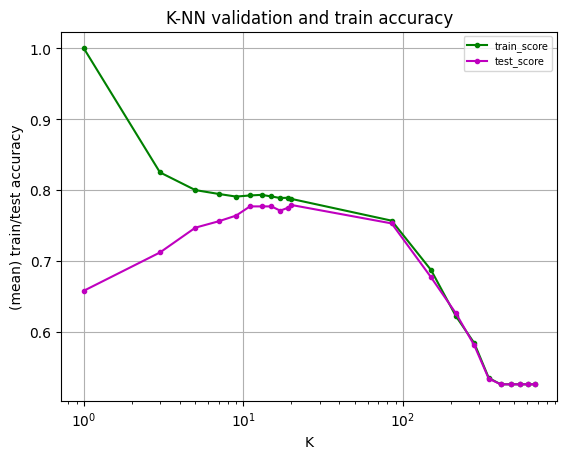

In [17]:
plt.semilogx('k', 'train_score', "g.-", data = h_parameters)
plt.semilogx('k', 'test_score', "m.-", data = h_parameters)
plt.xlabel ('K')
plt.ylabel ('(mean) train/test accuracy')
plt.title("K-NN validation and train accuracy")
plt.legend(prop = {'size':7},bbox_to_anchor=(1,1))
plt.grid()

In [18]:
best_k_scores = h_parameters[h_parameters['test_score']==h_parameters['test_score'].max()]
best_k = int(best_k_scores['k'].iloc[0])
best_k_scores

,k,test_score,train_score
10,20.0,0.779,0.787571


# Q2
The best `k` value is $20$, it scores $0.779$ validation accuracy and $0.787571$ train accuracy (average score estimated by cross validation).\
according to the curveplot, `k` values under $10$ lead to overfitting because trainiing accuracy is alot higher than validation accuracy. values over $20$ lead to underfitting, as we can see the accuracy for both train and validation drop significantly.


# Q3

In [19]:
q1_classifier = KNeighborsClassifier(n_neighbors=best_k)

q1_classifier.fit(X=temp_train_df[['PCR_01','PCR_08']], y=temp_train_df['spread'])
q1_train_accuracy = q1_classifier.score(temp_train_df[['PCR_01', 'PCR_08']], temp_train_df['spread'])
q1_test_accuracy = q1_classifier.score(temp_test_df[['PCR_01', 'PCR_08']], temp_test_df['spread'])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


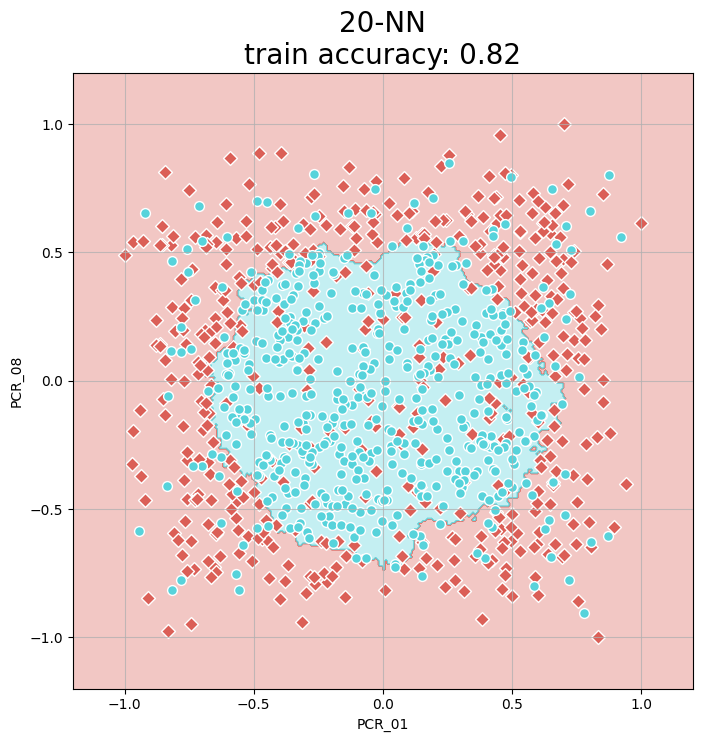

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


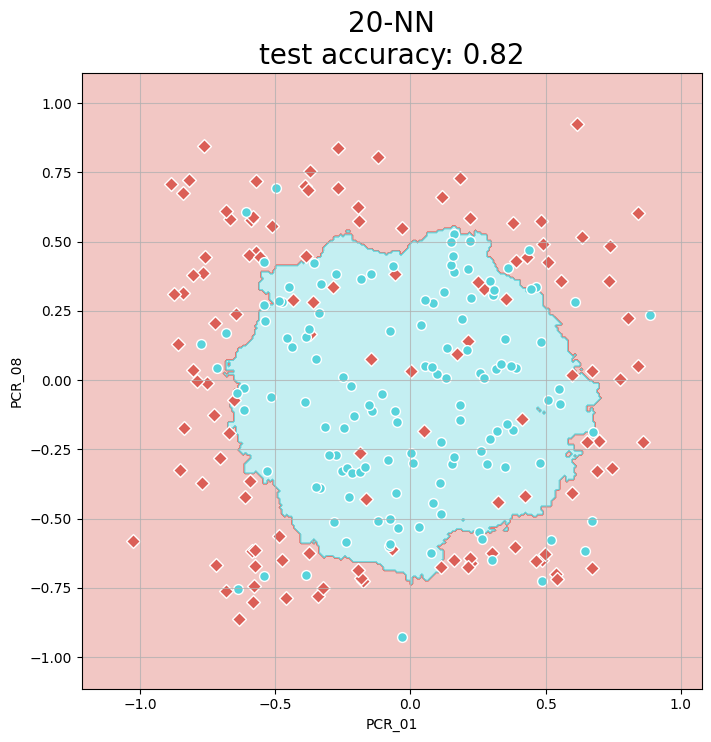

In [20]:
visualize_clf(q1_classifier, temp_train_df[['PCR_01', 'PCR_08']], temp_train_df['spread'],
              f'{best_k}-NN\ntrain accuracy: {q1_test_accuracy}', 'PCR_01', 'PCR_08')

visualize_clf(q1_classifier, temp_test_df[['PCR_01', 'PCR_08']], temp_test_df['spread'],
              f'{best_k}-NN\ntest accuracy: {q1_test_accuracy}', 'PCR_01', 'PCR_08')

# Q4

First of all, notice how the 20-NN test accuracy is $0.82$ and 1-NN is $0.704$. Already we can tell that we have improved the model significantly.\
By observing the boundaries of the two models we can see how the 1-NN model has encountered overfitting. the boundary has alot of small "islands", contrary to the 20-NN model which shows 1 large area that classifies the data more reliably.

# Part 2

train accuracy:  0.719
test accuracy:  0.584


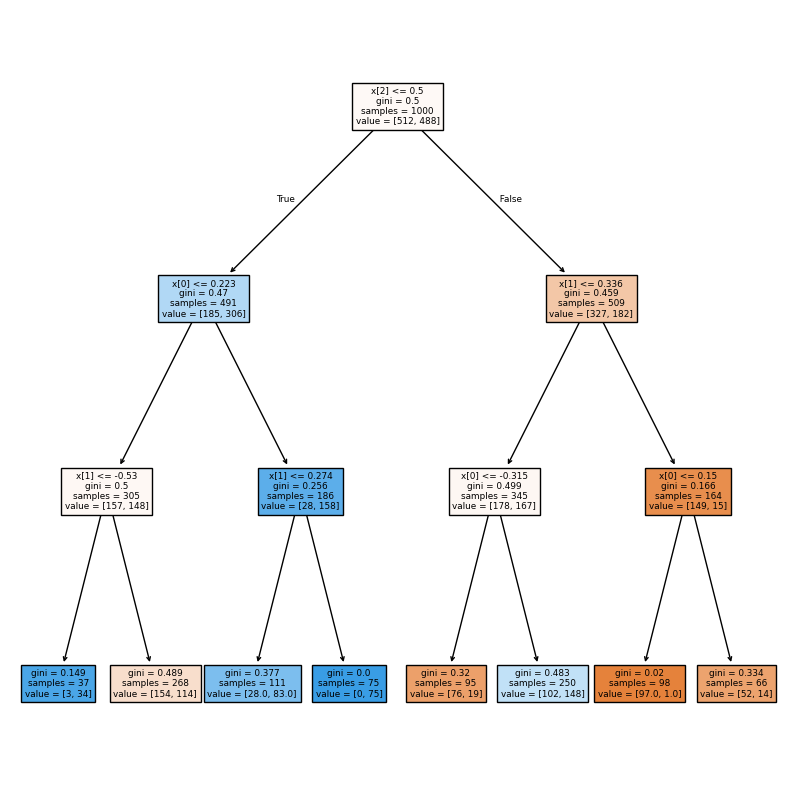

In [21]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

part2_train_df = train_df[['PCR_04', 'PCR_06', 'blood_type_group', 'risk']]
part2_test_df = test_df[['PCR_04', 'PCR_06', 'blood_type_group', 'risk']]

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(part2_train_df[['PCR_04', 'PCR_06', 'blood_type_group']], part2_train_df['risk'])

print('train accuracy: ', clf.score(X=part2_train_df[['PCR_04', 'PCR_06', 'blood_type_group']], y=part2_train_df['risk']))
print('test accuracy: ', clf.score(X=part2_test_df[['PCR_04', 'PCR_06', 'blood_type_group']], y=part2_test_df['risk']))

_ = plt.figure(figsize=(10,10))
_ = plot_tree(clf, filled=True)

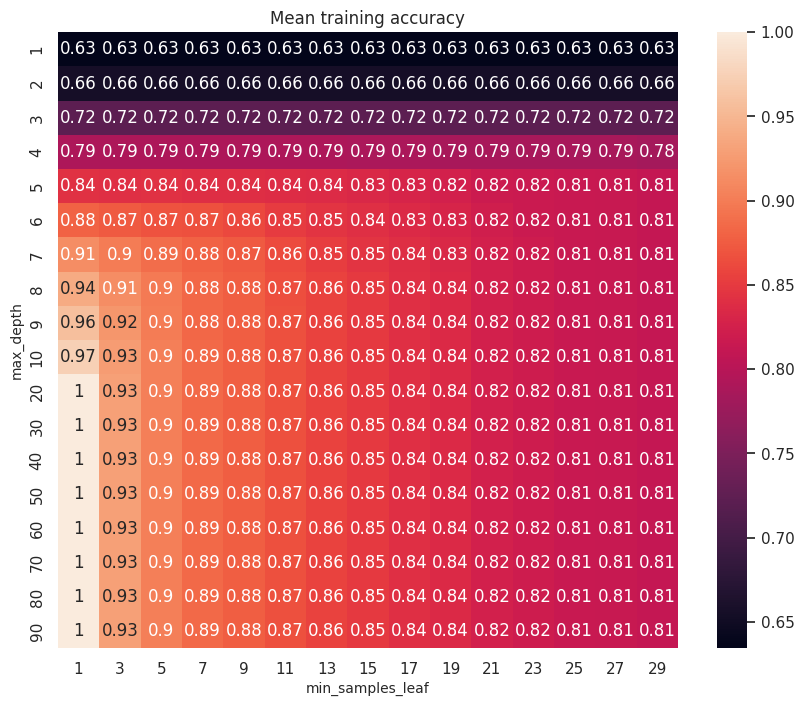

In [22]:
from sklearn.model_selection import cross_validate, GridSearchCV

folds = 5

depths = list(range(1,10)) + list(range(10,100,10))
min_samples_leaf = list(range(1,30,2))

parameters = {'max_depth': depths, 'min_samples_leaf': min_samples_leaf}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, cv=folds, return_train_score=True)
clf.fit(part2_train_df[['PCR_04', 'PCR_06', 'blood_type_group']], part2_train_df['risk'])

train_scores = clf.cv_results_['mean_train_score'].reshape(len(depths),len(min_samples_leaf))
train_scores = pd.DataFrame(train_scores, columns=min_samples_leaf, index=depths)

sns.set_theme(rc={'figure.figsize':(10,8)})

t = sns.heatmap(train_scores, annot=True, yticklabels=depths, xticklabels=min_samples_leaf)
t.set_xlabel('min_samples_leaf', fontsize=10)
t.set_ylabel('max_depth', fontsize=10)
_ = t.set(title="Mean training accuracy")

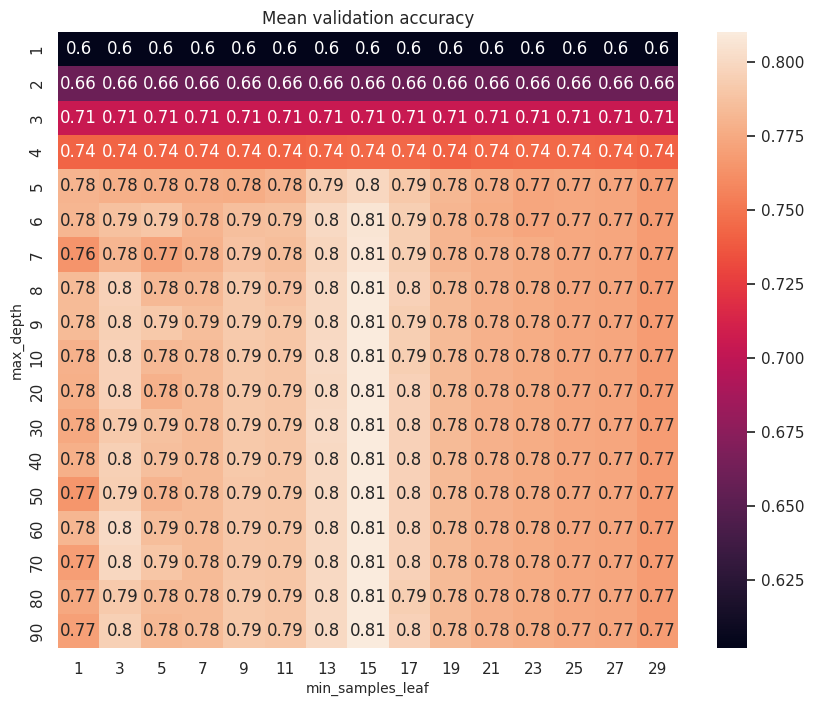

In [23]:
test_scores = clf.cv_results_['mean_test_score'].reshape(len(depths),len(min_samples_leaf))
test_scores = pd.DataFrame(test_scores, columns=min_samples_leaf, index=depths)
s = sns.heatmap(test_scores, annot=True, yticklabels=depths, xticklabels=min_samples_leaf)
s.set_xlabel('min_samples_leaf', fontsize=10)
s.set_ylabel('max_depth', fontsize=10)
_ = s.set(title="Mean validation accuracy")

# Q6
optimal hyperparameter values are:\
`min_samples_leaf` = 15\
`max_depth` = 8 (increasing beyond this point doesn't change the score significantly)

### D
As we can see by the plots, overfitting occurs for low `min_samples_leaf` values.
### E
underfitting occurs for low `max_depth` values
### F
overfitting occurs for low `min_samples_leaf` values because if we let the model classify a single datapoint in the train set with a single leaf (for `min_samples_leaf`), the tree will just 'remember' each datapoints value. that makes the model overfit with the train data.

underfitting occurs for low `max_depth` values because a shallow tree might not be able to correctly classify the dataset. for example, a tree of depth 1 could only split the dataset into 2 groups using 1 feature. That isn't complex enough for our dataset.

# Q7

for another hyper parameter, the number of combinations would be $n^3$, where $n$ is the number of values we evaluate for each parameter.\
Now, we only evaluated $n^2$ combinations.

In short, the number of hyperparameter combinations we have to evaluate grows exponentialy with the amount of hyperparameters we have.

# Q8

train accuracy:  0.857
test accuracy:  0.736


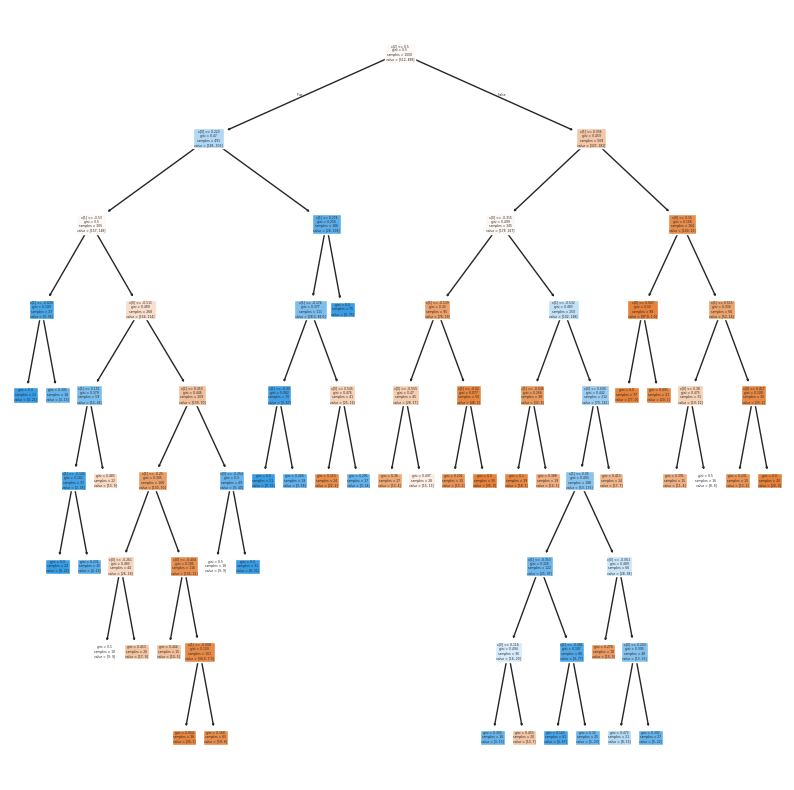

In [24]:
clf = DecisionTreeClassifier(max_depth=8, min_samples_leaf=15)
clf.fit(part2_train_df[['PCR_04', 'PCR_06', 'blood_type_group']], part2_train_df['risk'])

print('train accuracy: ', clf.score(X=part2_train_df[['PCR_04', 'PCR_06', 'blood_type_group']], y=part2_train_df['risk']))
print('test accuracy: ', clf.score(X=part2_test_df[['PCR_04', 'PCR_06', 'blood_type_group']], y=part2_test_df['risk']))

_ = plt.figure(figsize=(10,10))
_ = plot_tree(clf, filled=True)

test accuracy:  0.736

# Part 3

In [25]:
a = np.array([[-2,3],[4,5]]).reshape(1,-1)
b = np.array([[1,2],[-1,2]]).reshape(1,-1)
X = np.array([[11,22,-9,2],[10,20,-9,2]])
print(a)
print(b)
print(b*a)
print(a*b)
print(np.multiply(a,b))
print(np.multiply(b,a))
print(b.dot(a.reshape(-1,1)))
# g_w = 2*w + C*np.sum(errors * X, axis=0)
print(X)
print(a*X)
print(np.sum(a*X, axis=0))

[[-2  3  4  5]]
[[ 1  2 -1  2]]
[[-2  6 -4 10]]
[[-2  6 -4 10]]
[[-2  6 -4 10]]
[[-2  6 -4 10]]
[[10]]
[[11 22 -9  2]
 [10 20 -9  2]]
[[-22  66 -36  10]
 [-20  60 -36  10]]
[-42 126 -72  20]


In [26]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5, batch_size = 32):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = batch_size
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))

        norm = np.linalg.norm(w)

        # TODO: complete the loss calculation
        hinge_losses = np.maximum(0, 1 - hinge_inputs)
        loss = norm**2 + C * np.sum(hinge_losses)

        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical sub-gradient of soft-SVM w.r.t w and b
        margins = (X.dot(w) + b).reshape(-1, 1)

        sign_inputs = np.multiply(margins, y.reshape(-1, 1))

        signs = np.sign(np.minimum(0, sign_inputs - 1))
        errors = np.multiply(y.reshape(-1, 1), signs)

        g_w = 2*w + C*np.sum(errors * X, axis=0)
        g_b = C*np.sum(errors)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        permutation = np.random.permutation(len(y))
        X = X[permutation, :]
        y = y[permutation]

        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx:end_idx, :]
            batch_y = y[start_idx:end_idx]

            # TODO: Compute the (sub)gradient of the current *batch*
            g_w, g_b = self.subgradient(self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step
            # TODO: update the learned parameters correctly
            self.w -= self.lr * g_w
            self.b -= self.lr * g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
                 NOTE: the labels must be either +1 or -1
        """
        # TODO: compute the predicted labels (+1 or -1)
        decision_scores = X.dot(self.w) + self.b
        y_pred = np.sign(decision_scores)
        y_pred[y_pred == 0] = 1

        return y_pred



In [27]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b



def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


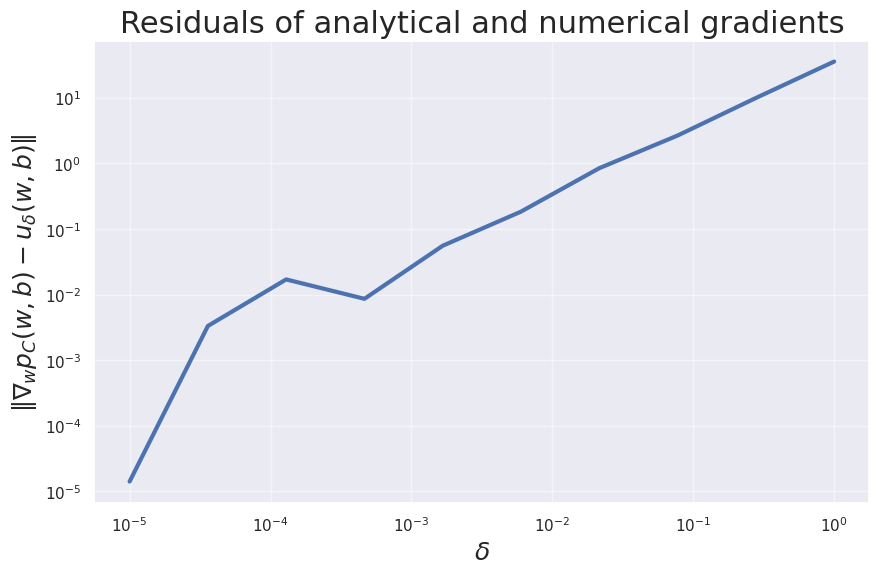

In [28]:
part_2_train_x = train_df[['PCR_01', 'PCR_08']]
part_2_train_y = train_df['spread']

part_2_test_x = test_df[['PCR_01', 'PCR_08']]
part_2_test_y = test_df['spread']

compare_gradients(part_2_train_x.values, part_2_train_y.values, deltas=np.logspace(-5, 0, 10))

# Q9

This plot shows how the difference between the numeric sub-gradient and the analytic sub-gradient (our implementation) converges to 0 as $\delta \rightarrow 0$.

The numeric sub-gradient converges to the true sub-gradient. according to the plot it also converges to the analytic sub-gradient we implemented, which means the implementation is correct.

# Q10

The loss graph seems to be minimizing quite quickly at first sight. But notice how the scale of the graph is between $[10^{14},12\times 10^{14}]$. That isn't a significant change for the loss function.\
The train accuracy oscillates in the range $[0.42, 0.54]$, this too is a very bad accuracy.
you can clearly tell that the loss is high and accuracy low by the desicion regions plotted, the division seems quite random.

test accuracy: 0.632


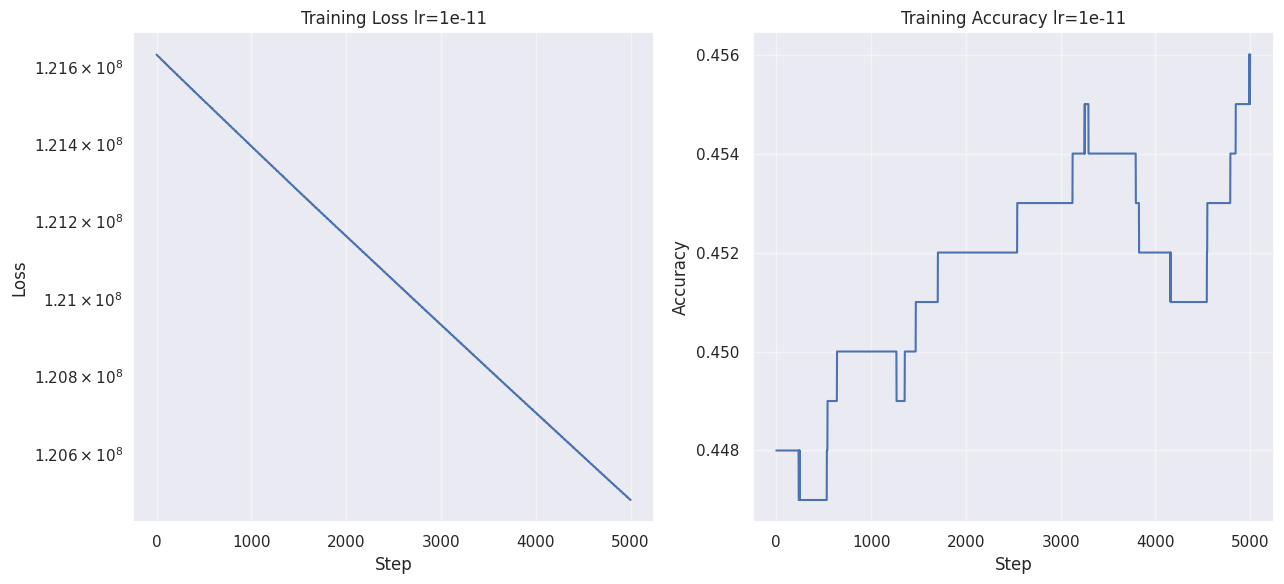

test accuracy: 0.708


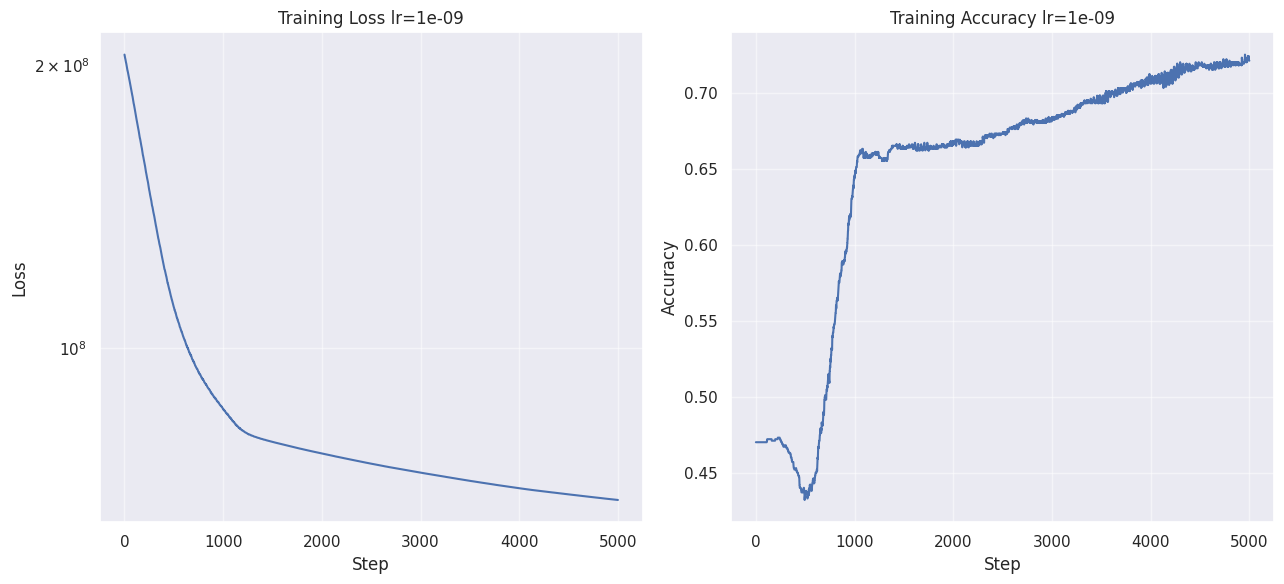

test accuracy: 0.816


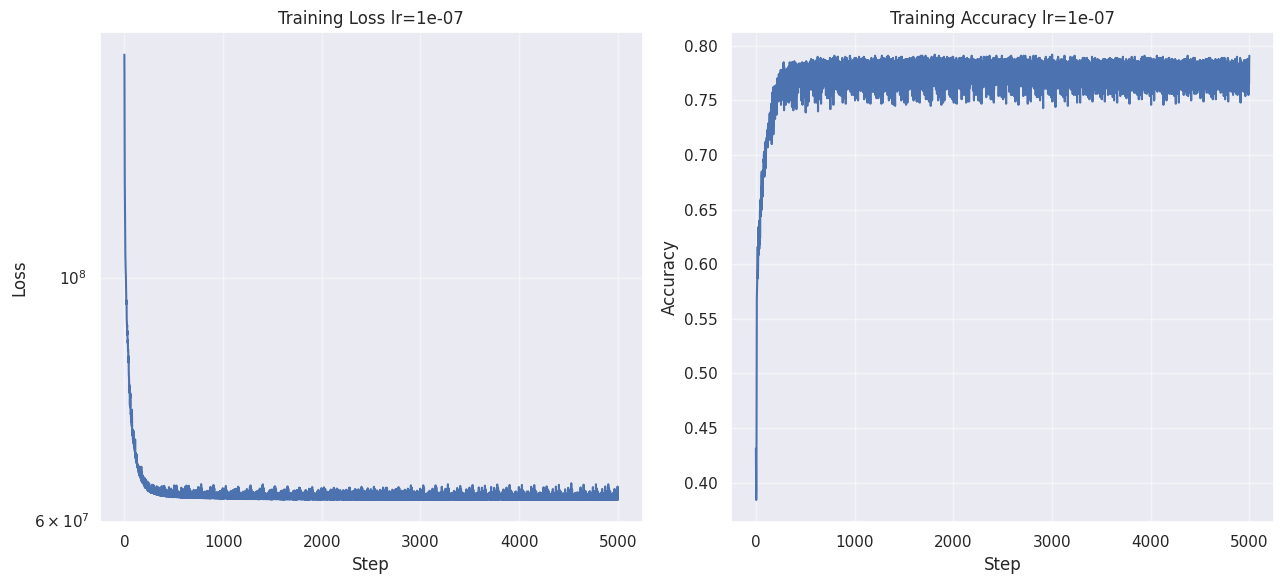

test accuracy: 0.58


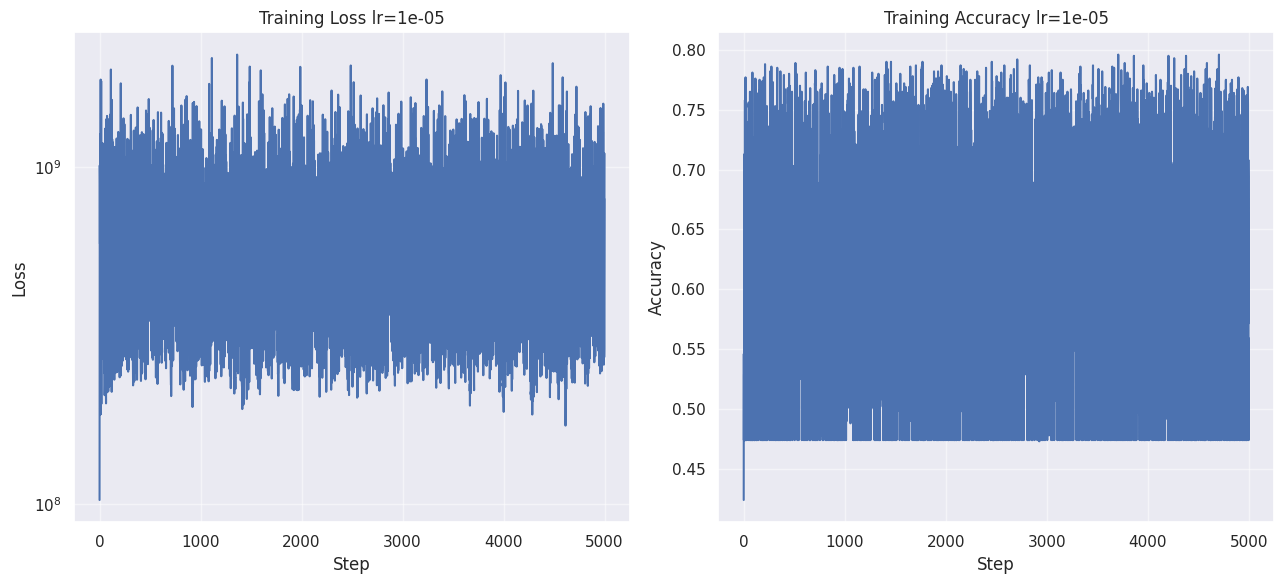

test accuracy: 0.728


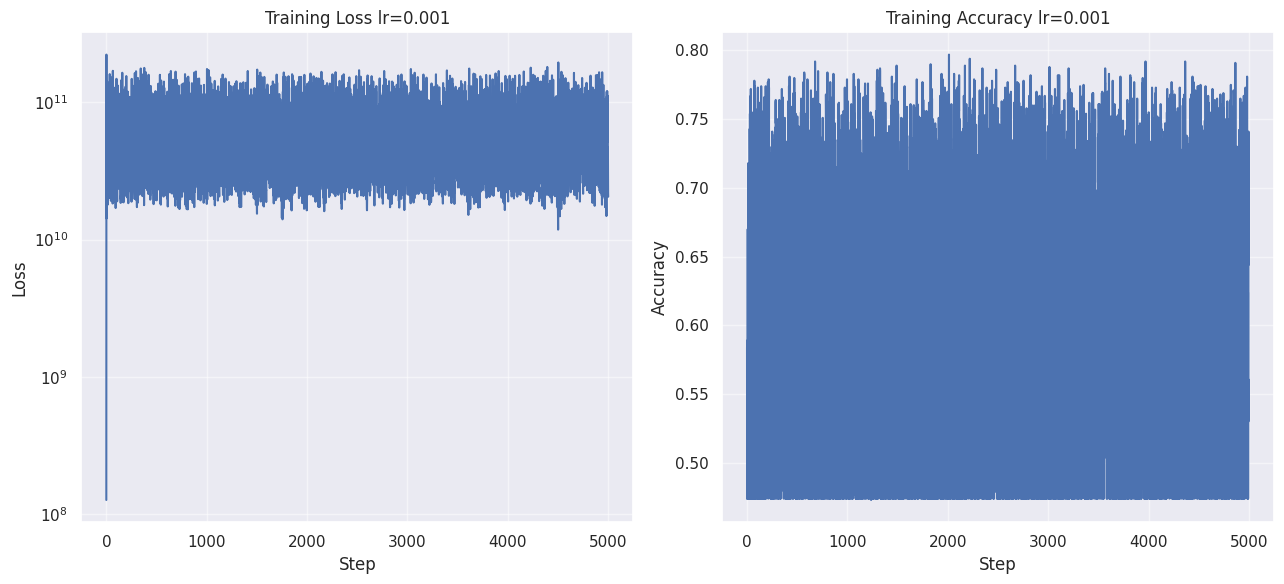

test accuracy: 0.82


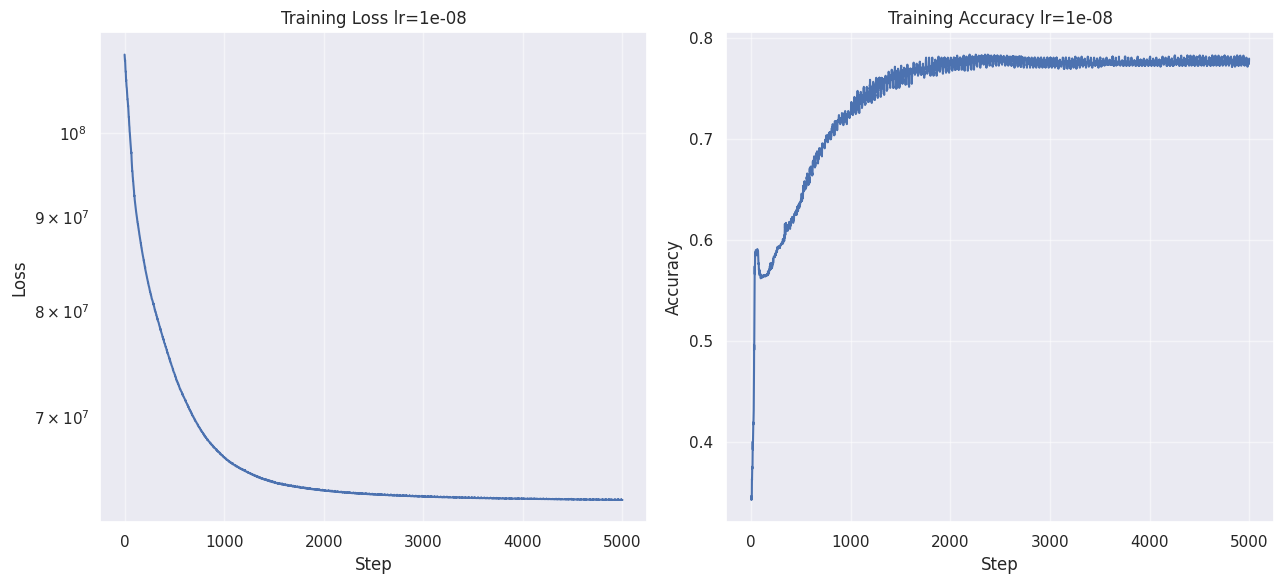

In [29]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

for lr in list(np.logspace(-11, -3, 5)) + [1e-8]:
  C=1e5
  clf = SoftSVM(C=C, lr=lr)
  X_train_poly = PolynomialFeatures(degree=3,).fit_transform(part_2_train_x)
  X_train_poly = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_train_poly)
  X_test_poly = PolynomialFeatures(degree=3,).fit_transform(part_2_test_x)
  X_test_poly = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_test_poly)

  losses, accuracies = clf.fit_with_logs(X_train_poly, part_2_train_y.values, max_iter=5000)
  print('test accuracy:', clf.score(X=X_test_poly, y=part_2_test_y))

  plt.figure(figsize=(13, 6))
  plt.subplot(121), plt.grid(alpha=0.5), plt.title (f"Training Loss lr={lr}")
  plt.semilogy(losses), plt.xlabel("Step"), plt.ylabel("Loss")
  plt.subplot(122), plt.grid(alpha=0.5), plt.title (f"Training Accuracy lr={lr}")
  plt.plot(accuracies), plt.xlabel("Step"), plt.ylabel("Accuracy")
  plt.tight_layout()
  plt.show()

# Q11

We would choose `lr`=$10^{-7}$ because it reaches the highest accuracy while staying relatively stable.\
We also added $10^{-8}$ to the `lr` range to get a middle-ground which will be even more stable and it has reached a higher train accuracy.\
In the end, we checked the test accuracy which was highest for `lr`=$10^{-7}$, so we will continue with that.

In [48]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),
 ('scaler', MinMaxScaler()),
  ('SVM', SoftSVM(C=1e5, lr=1e-7))])
svm_clf.fit(part_2_train_x.values, part_2_train_y.values)

Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=3)),
                ('scaler', MinMaxScaler()),
                ('SVM', SoftSVM(C=100000.0, lr=1e-07))])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


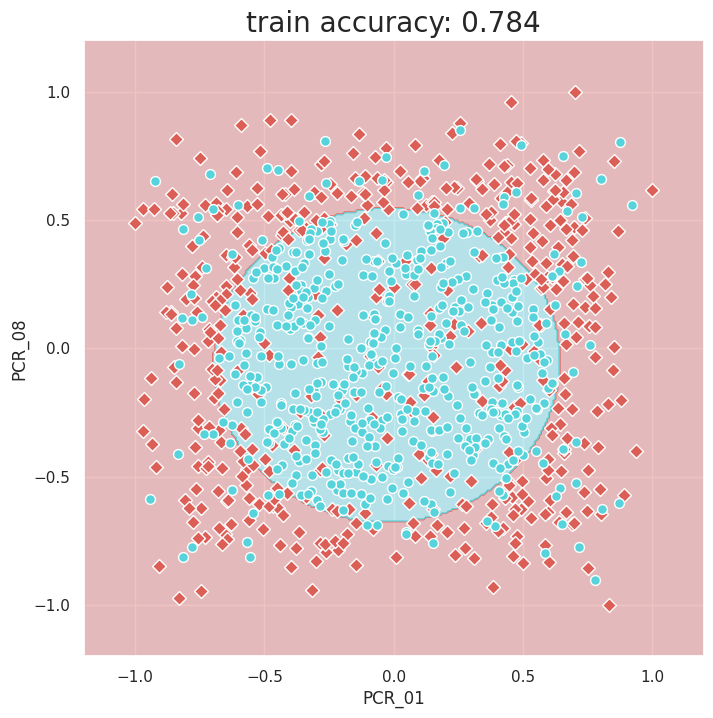

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


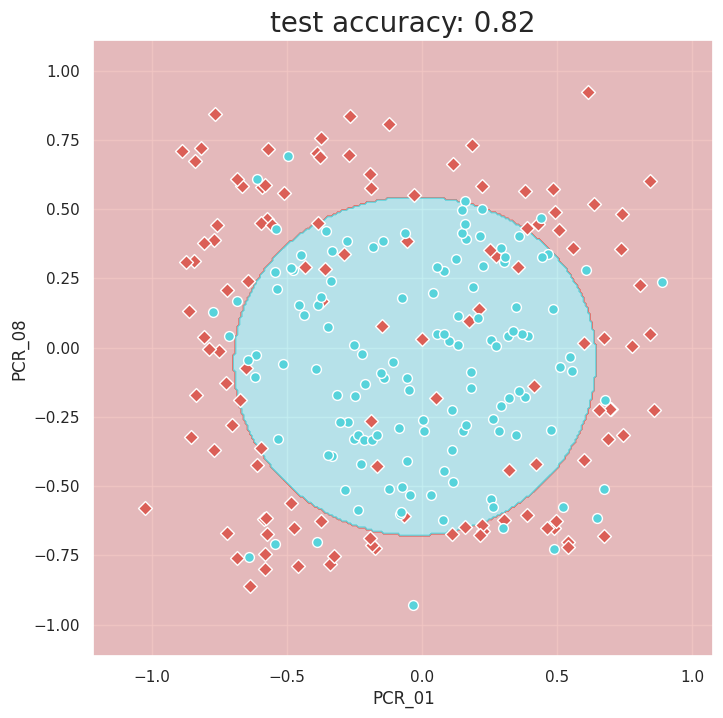

In [52]:
train_accuracy = svm_clf.score(part_2_train_x, part_2_train_y)

_ = visualize_clf(svm_clf, part_2_train_x, part_2_train_y,
              f'train accuracy: {train_accuracy}', 'PCR_01', 'PCR_08')

test_accuracy = svm_clf.score(part_2_test_x, part_2_test_y)

_ = visualize_clf(svm_clf, part_2_test_x, part_2_test_y,
              f'test accuracy: {test_accuracy}', 'PCR_01', 'PCR_08')

# Q13

## section 1
### a
$|S_j \cap S_j| = \langle \phi(S_i),\phi(S_j) \rangle = \sum_{k=1}^d(phi(S_i))_k\cdot(\phi(S_j))_k$\
As explained in the [wikipedia article](https://en.wikipedia.org/wiki/One-hot#:~:text=In%20natural%20language%20processing%2C%20a,uniquely%20to%20identify%20the%20word.), each entry $\phi(S)_i$ in $\phi(S)\in\mathbb{R}^d$ is $1$ if word $i$ is in email $S$, and $0$ otherwise.\
There are two options for every entry in the dot product $\sum_{k=1}^d(phi(S_i))_k\cdot(\phi(S_j))_k$.\
Option 1: the k-th word in $\Omega$ exists in both emails $\Rightarrow (phi(S_i))_k = (\phi(S_j))_k = 1 = (phi(S_i))_k\cdot(\phi(S_j))_k$\
Option 2: the k-th word in $\Omega$ _Doesnt_ in one of the emails $\Rightarrow (phi(S_i))_k = 0 \lor (\phi(S_j))_k = 0 \Rightarrow (phi(S_i))_k\cdot(\phi(S_j))_k = 0$

Therefore, the sum $\sum_{k=1}^d(phi(S_i))_k\cdot(\phi(S_j))_k$ counts how many words the emails have in common. which is equal to $|S_j \cap S_j|$\

We showed how the kernel $|S_j \cap S_j| = \langle \phi(S_i),\phi(S_j) \rangle$, therefore it is a valid kernel.

### b
Using rule 1 for recursively defined kernels, $k(a,b)=e^{k'(a,b)}$ is a valid kernel if $k'(a,b)$ is a valid kernel.\
As we just proved, $|S_j \cap S_j|$ is a valid kernel and therefore $k_{spam}(S_j, S_j)=e^{|S_j \cap S_j|}$ is also a valid kernel.